# <center>Simple decision tree</center>

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import confusion_matrix
import graphviz
%matplotlib inline
sns.set()

We will load data from data.npz file.

In [11]:
# Load all numpy arrays except training images (in order to save memory).
def load_data():
    with np.load('data.npz', allow_pickle=True) as npz_file:
        #X_train = npz_file['X_train']
        X_valid = npz_file['X_valid']
        X_test = npz_file['X_test']
        X_train_features = npz_file['X_train_features']
        X_valid_features = npz_file['X_valid_features']
        X_test_features = npz_file['X_test_features']
        y_train_1h = npz_file['y_train_1h']
        y_valid_1h = npz_file['y_valid_1h']
        y_test_1h = npz_file['y_test_1h']
        y_train = npz_file['y_train']
        y_valid = npz_file['y_valid']
        y_test = npz_file['y_test']
        class_indices = npz_file['class_indices']
        train_filenames = npz_file['train_filenames']
        valid_filenames = npz_file['valid_filenames']
        test_filenames = npz_file['test_filenames']
    return X_train_features, y_train_1h, y_train, train_filenames, X_valid,X_valid_features, y_valid_1h, y_valid, valid_filenames, X_test, X_test_features, y_test_1h, y_test, test_filenames,class_indices

# load training images
def load_images():
    with np.load('data.npz', allow_pickle=True) as npz_file:
        X_train = npz_file['X_train']
    return X_train

# merge two dictionaries
def merge_dict(x,y):
    d = x.copy()
    d.update(y)
    return d

# fit a model
def fit_model(model, grid, X_tr, y_tr, X_va, y_va, X_t, y_t):
    valid_scores = []
    train_scores = []
    params = []
    for params_dict in grid:
        #print (params_dict)
        params.append(params_dict)
        model.set_params(**params_dict)
        model.fit(X_tr, y_tr)
        train_scores.append(model.score(X_tr, y_tr))
        valid_scores.append(model.score(X_va, y_va))
    best_index = np.argmax(valid_scores)
    # refit model with best params
    model.set_params(**params[best_index])
    model.fit(X_tr, y_tr)
    test_score = model.score(X_t, y_t)
    return { 'best_params':params[best_index],
              'params':params,
             'train_scores':train_scores,
             'valid_scores':valid_scores,
             'test_score':test_score,
             'best_index':best_index,
              'best_valid_score':valid_scores[best_index],
              'best_model':model
            }

X_train_features, y_train_1h, y_train, train_filenames, X_valid,X_valid_features, y_valid_1h, y_valid, valid_filenames, X_test, X_test_features, y_test_1h, y_test, test_filenames,class_indices = load_data()


## Simple decision trees
- Can you do better than the k-NN baseline with decision trees?

Let's train a DecisionTreeClassifier with many grid hyperparams :


In [8]:
grid = ParameterGrid({
'max_depth': np.arange(1,20),
'criterion': ['gini', 'entropy']
})

dt_model = DecisionTreeClassifier(random_state=0)

fit_dt = fit_model(dt_model, grid, X_train_features, y_train, X_valid_features, y_valid, X_test_features, y_test)

{'criterion': 'gini', 'max_depth': 1}
{'criterion': 'gini', 'max_depth': 2}
{'criterion': 'gini', 'max_depth': 3}
{'criterion': 'gini', 'max_depth': 4}
{'criterion': 'gini', 'max_depth': 5}
{'criterion': 'gini', 'max_depth': 6}
{'criterion': 'gini', 'max_depth': 7}
{'criterion': 'gini', 'max_depth': 8}
{'criterion': 'gini', 'max_depth': 9}
{'criterion': 'gini', 'max_depth': 10}
{'criterion': 'gini', 'max_depth': 11}
{'criterion': 'gini', 'max_depth': 12}
{'criterion': 'gini', 'max_depth': 13}
{'criterion': 'gini', 'max_depth': 14}
{'criterion': 'gini', 'max_depth': 15}
{'criterion': 'gini', 'max_depth': 16}
{'criterion': 'gini', 'max_depth': 17}
{'criterion': 'gini', 'max_depth': 18}
{'criterion': 'gini', 'max_depth': 19}
{'criterion': 'entropy', 'max_depth': 1}
{'criterion': 'entropy', 'max_depth': 2}
{'criterion': 'entropy', 'max_depth': 3}
{'criterion': 'entropy', 'max_depth': 4}
{'criterion': 'entropy', 'max_depth': 5}
{'criterion': 'entropy', 'max_depth': 6}
{'criterion': 'entropy

Best params, best validation score, and test accuracy score are :

In [9]:
print('Best params : ', fit_dt['best_params'])
print('Best validation score : ', fit_dt['best_valid_score'])
print('Test score : ', fit_dt['test_score'])

Best params :  {'criterion': 'gini', 'max_depth': 7}
Best validation score :  0.8633093525179856
Test score :  0.84


A DecisionTreeClassifier does not perform better than KNN. It's test accuracy (84%) is less than the KNN one (92%).



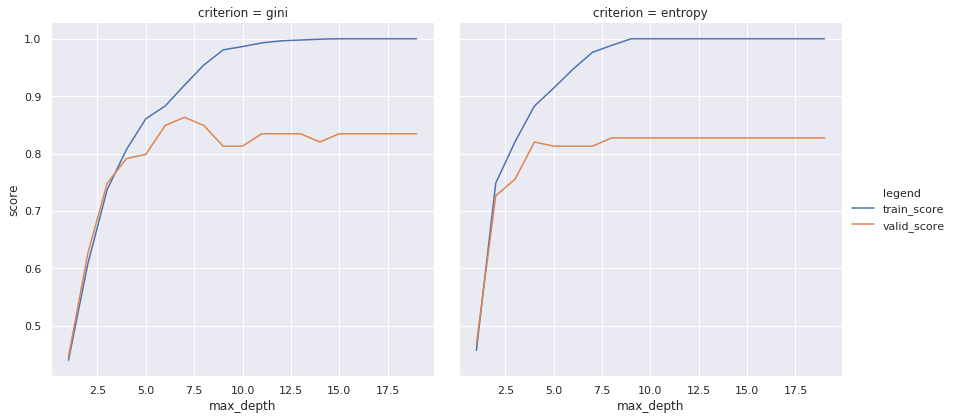

In [12]:
dt = pd.DataFrame([ merge_dict(x, {'valid_score':fit_dt['valid_scores'][i],'train_score':fit_dt['train_scores'][i]}) for i, x in enumerate(fit_dt['params']) ])
data=pd.melt(dt, id_vars=['criterion','max_depth'], value_vars=['train_score','valid_score'], var_name='legend', value_name='score')
g = sns.FacetGrid(data, col="criterion", height=6)
g = g.map(sns.lineplot, "max_depth", "score","legend")
g.add_legend();

- What accuracy can you achieve with a depth of 3?

For validation score, we can achieve an accuracy of 75% :

In [13]:
dt[dt.max_depth==3]

,criterion,max_depth,train_score,valid_score
2,gini,3,0.737143,0.748201
21,entropy,3,0.820714,0.755396


The test score for this model is 78% :

In [14]:
dt_model_3 = DecisionTreeClassifier(random_state=0,criterion='entropy',max_depth=3)
dt_model_3.fit(X_train_features,y_train)
dt_model_3.score(X_test_features, y_test)

0.78

- Plot the corresponding tree with graphviz

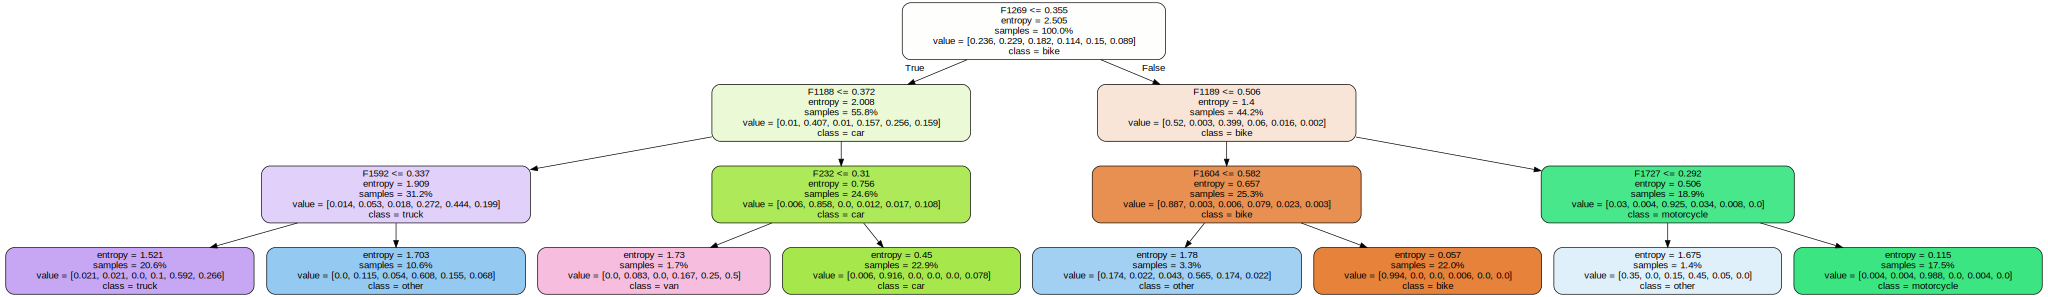

In [19]:
dot_data = export_graphviz( dt_model_3, out_file=None,
feature_names=['F'+str(i) for i in range(0,X_test_features.shape[1])], class_names=class_indices,
filled=True, rounded=True, proportion=True
)
graphviz.Source(dot_data)

As we can see, bikes and motorcycles are best predited with this decision tree (99% for bike and 98% for motrocycle).

- Do you get better results if you reduce the number of dimensions with PCA first?

We will add PCA to the pipeline :

In [20]:
grid = ParameterGrid({
'dt__max_depth': np.arange(1,20),
'dt__criterion': ['gini', 'entropy'],
'pca__n_components':np.arange(2,30)
})

dt_model_pca =  Pipeline([
('pca', PCA(random_state=0)),
('dt', DecisionTreeClassifier(random_state=0))
])


fit_dt_pca = fit_model(dt_model_pca, grid, X_train_features, y_train, X_valid_features, y_valid, X_test_features, y_test)

Best params, best validation score, and test accuracy score are :

In [21]:
print('Best params : ', fit_dt_pca['best_params'])
print('Best validation score : ', fit_dt_pca['best_valid_score'])
print('Test score : ', fit_dt_pca['test_score'])

Best params :  {'dt__criterion': 'entropy', 'dt__max_depth': 6, 'pca__n_components': 6}
Best validation score :  0.9064748201438849
Test score :  0.92


Adding PCA improves test accuracy. It passes from 84% to 92%).